<a href="https://colab.research.google.com/github/conkilaras-code/Life_annuity-calculator/blob/main/Life_Annuity_Calculator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9720 entries, 0 to 9719
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    9720 non-null   int64  
 1   x       9720 non-null   int64  
 2   q(x)    9720 non-null   float64
 3   l(x)    9720 non-null   int64  
 4   d(x)    9720 non-null   int64  
 5   L(x)    9720 non-null   int64  
 6   T(x)    9720 non-null   int64  
 7   e(x)    9720 non-null   float64
 8   D(x)    9720 non-null   int64  
 9   M(x)    9720 non-null   int64  
 10  A(x)    9720 non-null   float64
 11  N(x)    9720 non-null   int64  
 12  a(x)    9720 non-null   float64
 13  12a(x)  9720 non-null   float64
dtypes: float64(5), int64(9)
memory usage: 1.0 MB


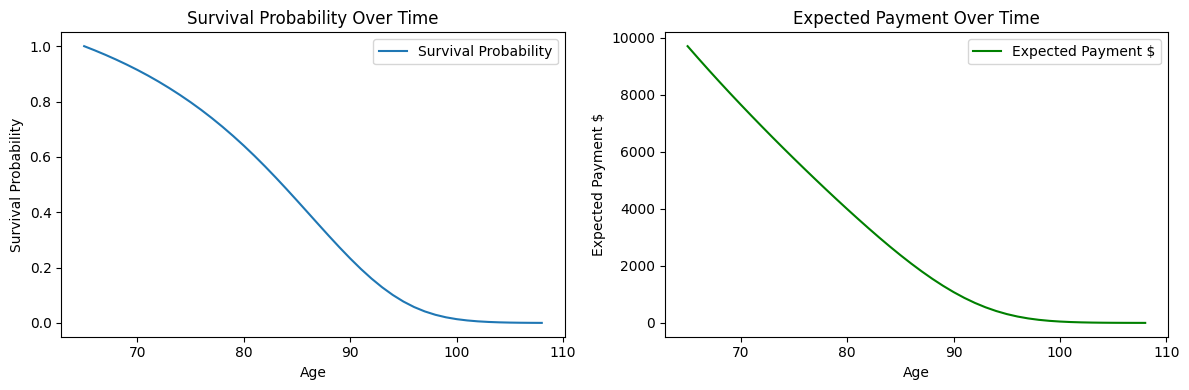

Expected present value of annuity: $134400.13


(np.float64(134400.1322888612),
         x      q(x)      p(x)  survival_prob     t      discount  \
 0      65  0.015203  0.984797       1.000000     1  9.708738e-01   
 1      66  0.016368  0.983632       0.984797     2  9.425959e-01   
 2      67  0.017649  0.982351       0.968678     3  9.151417e-01   
 3      68  0.019053  0.980947       0.951582     4  8.884870e-01   
 4      69  0.020612  0.979388       0.933451     5  8.626088e-01   
 ...   ...       ...       ...            ...   ...           ...   
 4450  115  0.475472  0.524528       0.000000  4451  7.269639e-58   
 4451  116  0.499246  0.500754       0.000000  4452  7.057902e-58   
 4452  117  0.524208  0.475792       0.000000  4453  6.852332e-58   
 4453  118  0.550419  0.449581       0.000000  4454  6.652749e-58   
 4454  119  0.577940  0.422060       0.000000  4455  6.458980e-58   
 
       expected_payment  
 0          9708.737864  
 1          9282.656235  
 2          8864.774484  
 3          8454.679688  
 4      

In [2]:
# Assumptions:
# 1. Payments begin at age 65
# 2. Survival probabilities are taken from the SSA projected life table (2015-2095)
# 3. Payments end immediately after death, no guarantee period
# 4. One-year survival probability, p(x), is independent each year
# 5. Expected present value is not adjusted for taxes and inflation

#Import packages and read with pandas, skipping nonessential rows in the CSV file
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

file_path = "/content/drive/MyDrive/PerLifeTables.csv"

life_table = pd.read_csv(file_path, skiprows=4, header=0)

#Exploratory Data Analysis, check structure, summary, and any missing values
life_table.head()
life_table.info()
life_table.describe()
life_table.isnull().sum()

#Life annuity function
def life_annuity(interest, payment,start_age=65,thresholds=True):
  """
  calculates expected present value for a life annuity beginning at start_age and visualizes survival probability and expected payments over time.

  Parameters:
    interest (float): Annual interest rate.
    payment (float): Annual annuity payment.
    start_age (int): Age at which payments begins.
    thresholds (bool): Includes threshold values for expected payment and survival probability in visualization.
  Returns:
    epv (float): Expected present value of annuity.
    lt_rel (DataFrame): DataFrame containing:
      - x: age
      - q(x): probability of dying within a year
      - p(x): one-year survival probability
      - survival_prob: conditional cumulative survival probability
      - discount: discount factor for each year
      - expected_payment: discounted expected payment for each year
  """
  #Raise errors
  if interest < 0:
    raise ValueError("Interest rate must be non-negative")
  if payment < 0:
    raise ValueError("Payments must be non-negative")
  if start_age < 0 or start_age > 120:
    raise ValueError("Start age must be between 0 and 120")
  #Filter life table table for relevant ages and columns
  lt_rel = life_table[life_table['x']>=start_age].reset_index(drop=True)
  lt_rel = lt_rel[['x','q(x)']]
  #Calculate one year survival probability, p(x)
  lt_rel['p(x)'] = 1 - lt_rel['q(x)']
  #Conditional cumulative survival probability, survival_prob
  lt_rel['survival_prob'] = lt_rel['p(x)'].cumprod().shift(1).fillna(1)
  #Compute discount factor based on assumptions
  lt_rel['t'] = range(1, len(lt_rel) + 1)
  lt_rel['discount'] = 1 / ((1 + interest) ** lt_rel['t'])
  # Compute expected payment for each year, then sum to get the expected present value
  lt_rel['expected_payment'] = lt_rel['survival_prob'] * payment * lt_rel['discount']
  epv = lt_rel['expected_payment'].sum()
  ###########################################
  #Plot survival probability and expected payment over time
  if thresholds==True:
    threshold_payment = 0.1 * payment
    threshold_survival = .0001
    lt_plot  = lt_rel[(lt_rel['survival_prob'] > threshold_survival) | (lt_rel['expected_payment'] > threshold_payment)] #Filters out negligible values
  else:
    lt_plot = lt_rel
  fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
  lt_plot.plot(x='x', y='survival_prob', ax=ax[0],label='Survival Probability')
  ax[0].set_xlabel('Age')
  ax[0].set_ylabel('Survival Probability')
  ax[0].set_title('Survival Probability Over Time')
  lt_plot.plot(x='x', y='expected_payment', ax=ax[1],color='green',label='Expected Payment $')
  ax[1].set_xlabel('Age')
  ax[1].set_ylabel('Expected Payment $')
  ax[1].set_title('Expected Payment Over Time')
  ax[0].legend()
  ax[1].legend()
  plt.tight_layout()
  plt.show()
  ###########################################
  #Print expected present value
  print(f"Expected present value of annuity: ${epv:.2f}")
  return epv, lt_rel

#Example call: $10,000/year annuity at 3% interest, starting at age 65
life_annuity(0.03,10000,65)